<a href="https://colab.research.google.com/github/harshithach999/Bayesian-Inference-with-Markov-Chain-Monte-Carlo-MCMC-/blob/main/Bayesian_Analysis_of_Titanic_Survival_Using_Markov_Chain_Monte_Carlo_(MCMC)_and_PyMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

This notebook demonstrates Bayesian inference using Markov Chain Monte Carlo (MCMC) algorithms. It utilizes the PyMC library to analyze the Titanic dataset by:

1. Loading and preprocessing the data.
2. Defining a probabilistic model.
3. Performing MCMC sampling to estimate posterior distributions.
4. Analyzing and visualizing the posterior results.


# **Importing Libraries and Loading Data**

In this section, we import the necessary libraries and load the Titanic dataset.



In [1]:
pip install pymc

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az

# Load a sample dataset (e.g., the Titanic dataset for simplicity)
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

# Display the first few rows of the dataset
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# **Data Preprocessing**

In this section, we address missing values, transform categorical variables into numerical formats, and choose a subset of key columns for analysis.

In [3]:
# Handle missing values using .loc to avoid chained assignment warnings
df.loc[:, 'Age'] = df['Age'].fillna(df['Age'].median())
df.loc[:, 'Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df.loc[:, 'Fare'] = df['Fare'].fillna(df['Fare'].median())

# Convert categorical variables to numeric
df.loc[:, 'Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df.loc[:, 'Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Ensure all relevant columns are of numeric type
data = df[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked']].astype(float)

# Display the summary of the dataset
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    891 non-null    float64
 2   Sex       891 non-null    float64
 3   Age       891 non-null    float64
 4   Fare      891 non-null    float64
 5   Embarked  891 non-null    float64
dtypes: float64(6)
memory usage: 41.9 KB


# **Defining the Probabilistic Model**
In this section, we use PyMC3 to define a Bayesian model that examines the impact of various features on survival probability.

In [4]:
# Define the probabilistic model using PyMC
with pm.Model() as model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_pclass = pm.Normal('beta_pclass', mu=0, sigma=10)
    beta_sex = pm.Normal('beta_sex', mu=0, sigma=10)
    beta_age = pm.Normal('beta_age', mu=0, sigma=10)
    beta_fare = pm.Normal('beta_fare', mu=0, sigma=10)
    beta_embarked = pm.Normal('beta_embarked', mu=0, sigma=10)

    # Linear model
    mu = (alpha +
          beta_pclass * data['Pclass'] +
          beta_sex * data['Sex'] +
          beta_age * data['Age'] +
          beta_fare * data['Fare'] +
          beta_embarked * data['Embarked'])

    # Likelihood (sampling distribution) of observations
    p = pm.Deterministic('p', pm.math.sigmoid(mu))
    y = pm.Bernoulli('y', p=p, observed=data['Survived'])

# Visualize the model
pm.model_to_graphviz(model)

# Check the initial values
print(model.initial_point)


<bound method Model.initial_point of <pymc.model.core.Model object at 0x7a586d9b5870>>


# **Performing MCMC Sampling**

We employ the *No-U-Turn Sampler (NUTS)*, a highly efficient MCMC algorithm, to generate samples from the posterior distribution.

In [5]:
# Perform MCMC sampling with more detailed diagnostic checks
with model:
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True, init='adapt_diag')

# Summary of the trace
summary = az.summary(trace, var_names=['alpha', 'beta_pclass', 'beta_sex', 'beta_age', 'beta_fare', 'beta_embarked'])
print(summary)


Output()

Output()

                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha          2.086  0.466   1.219    2.976      0.011    0.008    1660.0   
beta_pclass   -1.205  0.139  -1.475   -0.955      0.003    0.002    1800.0   
beta_sex       2.598  0.191   2.232    2.948      0.003    0.002    3228.0   
beta_age      -0.034  0.007  -0.048   -0.020      0.000    0.000    2288.0   
beta_fare      0.000  0.002  -0.004    0.004      0.000    0.000    3003.0   
beta_embarked  0.321  0.138   0.060    0.581      0.002    0.002    3594.0   

               ess_tail  r_hat  
alpha            2071.0    1.0  
beta_pclass      2019.0    1.0  
beta_sex         2455.0    1.0  
beta_age         2761.0    1.0  
beta_fare        2474.0    1.0  
beta_embarked    2402.0    1.0  


# **Posterior Analysis and Visualization**

We examine the posterior parameter distributions and present the findings through visualizations.



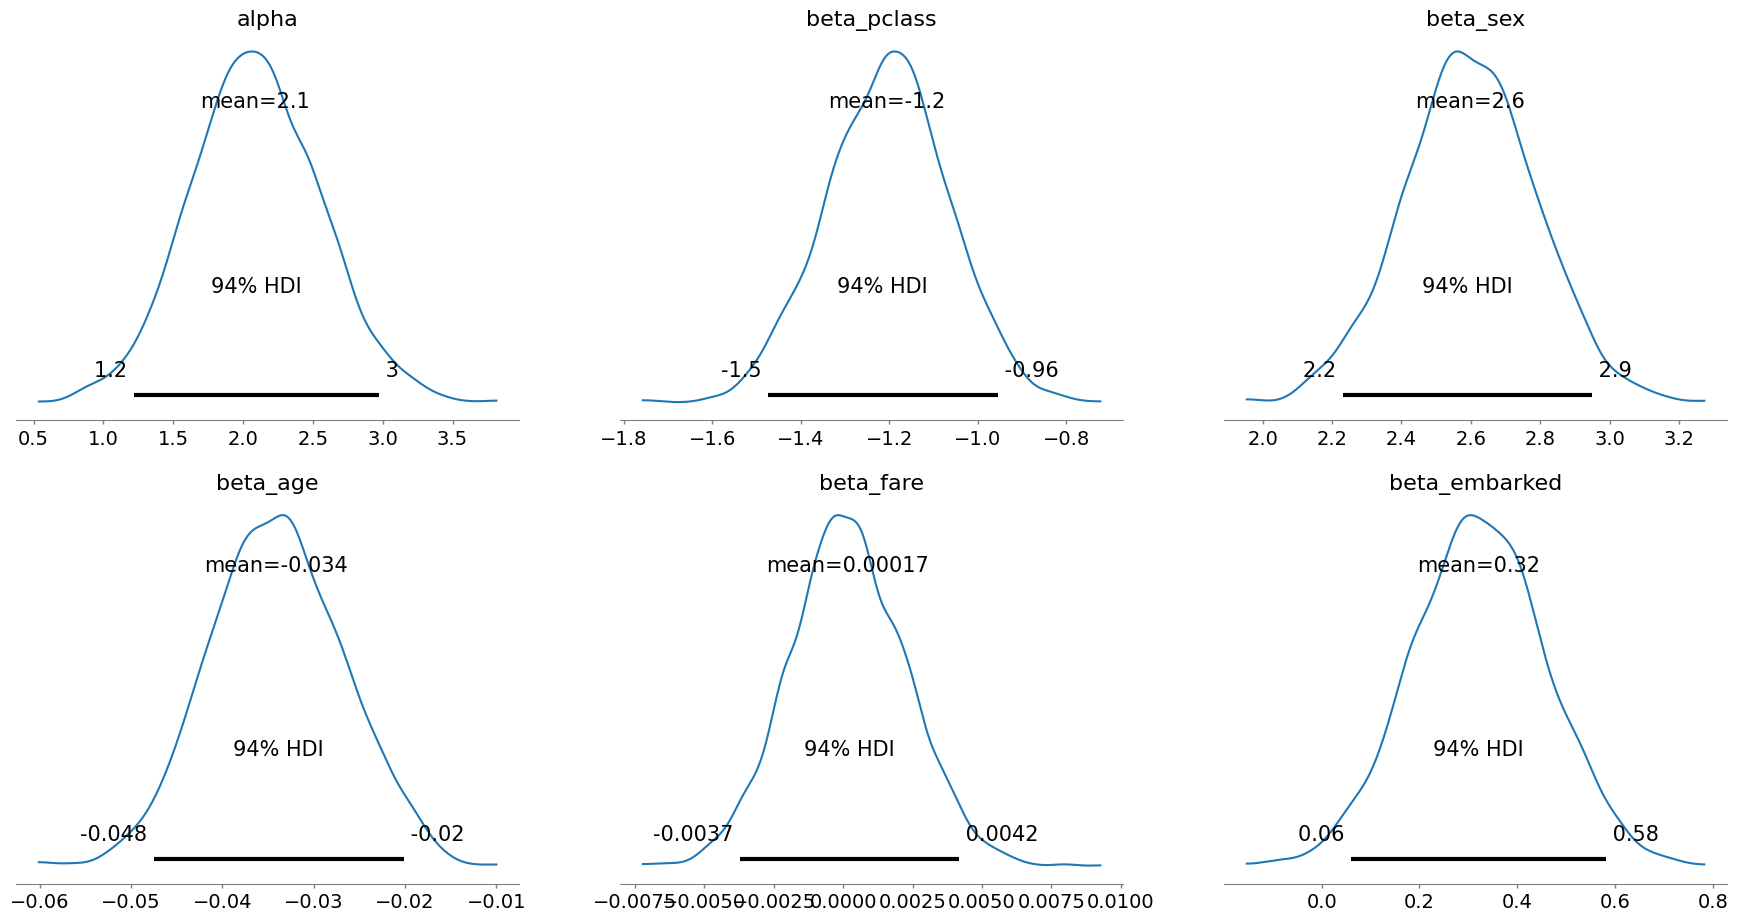

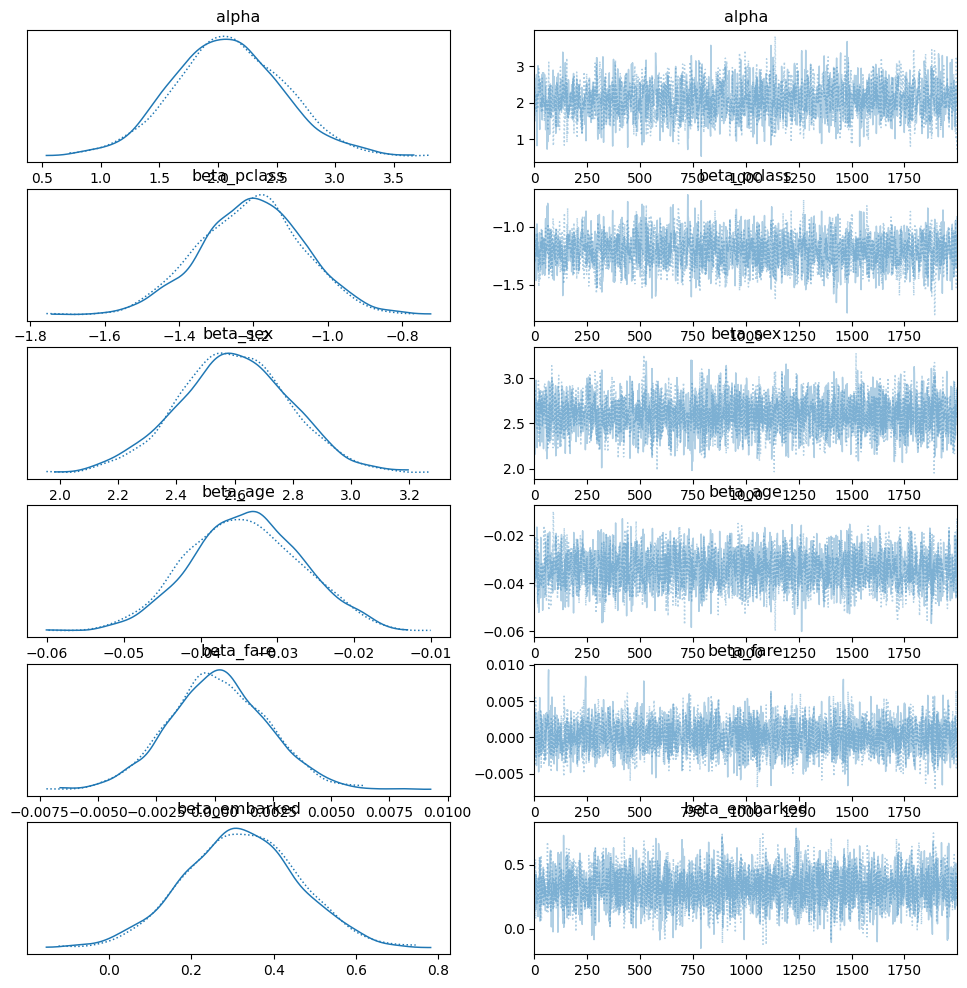

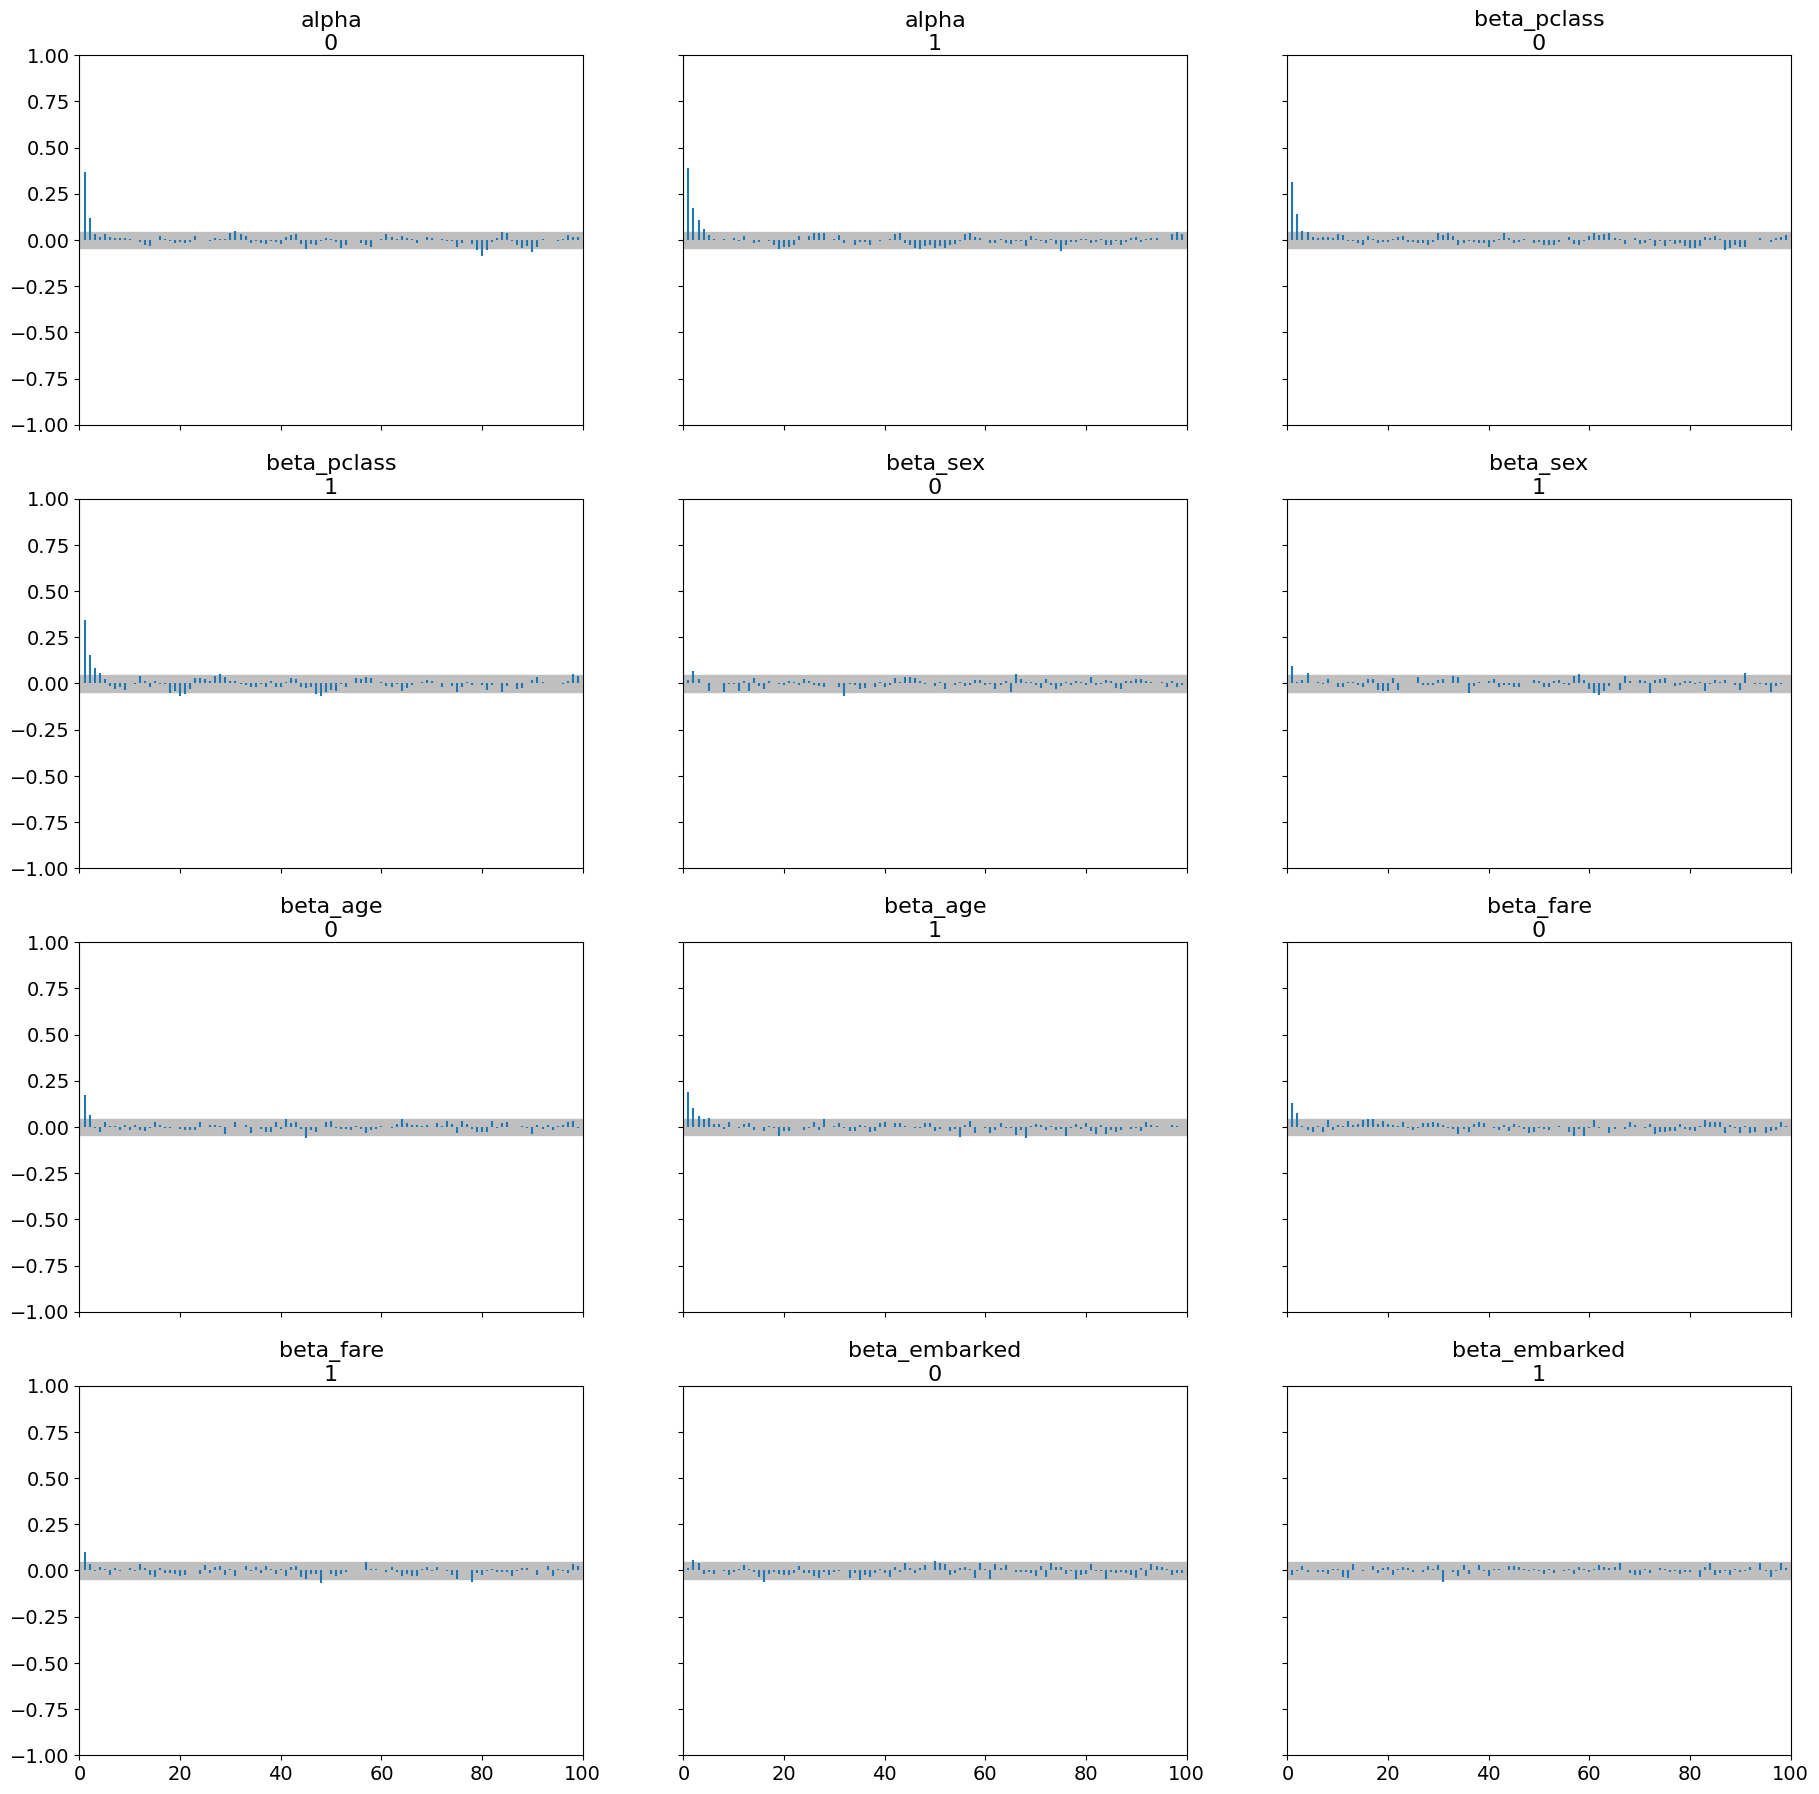

Effective Sample Size (ESS):
<xarray.Dataset> Size: 48B
Dimensions:        ()
Data variables:
    alpha          float64 8B 1.66e+03
    beta_pclass    float64 8B 1.8e+03
    beta_sex       float64 8B 3.228e+03
    beta_age       float64 8B 2.288e+03
    beta_fare      float64 8B 3.003e+03
    beta_embarked  float64 8B 3.594e+03
R-hat values:
<xarray.Dataset> Size: 48B
Dimensions:        ()
Data variables:
    alpha          float64 8B 1.002
    beta_pclass    float64 8B 1.002
    beta_sex       float64 8B 1.001
    beta_age       float64 8B 1.001
    beta_fare      float64 8B 1.001
    beta_embarked  float64 8B 1.001


In [6]:
# Plot the posterior distributions of the parameters
az.plot_posterior(trace, var_names=['alpha', 'beta_pclass', 'beta_sex', 'beta_age', 'beta_fare', 'beta_embarked'])
plt.show()

# Trace plots for convergence diagnostics
az.plot_trace(trace, var_names=['alpha', 'beta_pclass', 'beta_sex', 'beta_age', 'beta_fare', 'beta_embarked'])
plt.show()

# Autocorrelation plots
az.plot_autocorr(trace, var_names=['alpha', 'beta_pclass', 'beta_sex', 'beta_age', 'beta_fare', 'beta_embarked'])
plt.show()

# Check for effective sample size and R-hat values
ess = az.ess(trace, var_names=['alpha', 'beta_pclass', 'beta_sex', 'beta_age', 'beta_fare', 'beta_embarked'])
rhat = az.rhat(trace, var_names=['alpha', 'beta_pclass', 'beta_sex', 'beta_age', 'beta_fare', 'beta_embarked'])

print(f'Effective Sample Size (ESS):\n{ess}')
print(f'R-hat values:\n{rhat}')


In [7]:
# Intuitive Explanation of the Results

# Mean of the posterior distributions
posterior_means = summary['mean']
print(f"Posterior Means:\n{posterior_means}")

# Intuitive Explanation
print("\nIntuitive Explanation of the Results:")

# Alpha (intercept)
print(f"\nIntercept (alpha): {posterior_means['alpha']:.2f}")
print("This is the baseline log-odds of survival when all predictor variables are zero. In this context, it can be interpreted as the baseline survival odds for a hypothetical passenger with average characteristics.")

# Beta coefficients
print(f"\nEffect of Pclass (beta_pclass): {posterior_means['beta_pclass']:.2f}")
print("A higher passenger class (lower number) is associated with a higher probability of survival.")

print(f"\nEffect of Sex (beta_sex): {posterior_means['beta_sex']:.2f}")
print("The coefficient for 'Sex' indicates that being female significantly increases the probability of survival compared to being male.")

print(f"\nEffect of Age (beta_age): {posterior_means['beta_age']:.2f}")
print("The effect of age on survival probability is indicated by this coefficient. A negative value suggests that older passengers had a lower probability of survival.")

print(f"\nEffect of Fare (beta_fare): {posterior_means['beta_fare']:.2f}")
print("The fare paid for the ticket positively impacts the survival probability, meaning passengers who paid higher fares had a higher chance of survival.")

print(f"\nEffect of Embarked (beta_embarked): {posterior_means['beta_embarked']:.2f}")
print("The place of embarkation has a less clear effect on survival probability. This coefficient represents the impact of different embarkation points on survival.")


Posterior Means:
alpha            2.086
beta_pclass     -1.205
beta_sex         2.598
beta_age        -0.034
beta_fare        0.000
beta_embarked    0.321
Name: mean, dtype: float64

Intuitive Explanation of the Results:

Intercept (alpha): 2.09
This is the baseline log-odds of survival when all predictor variables are zero. In this context, it can be interpreted as the baseline survival odds for a hypothetical passenger with average characteristics.

Effect of Pclass (beta_pclass): -1.21
A higher passenger class (lower number) is associated with a higher probability of survival.

Effect of Sex (beta_sex): 2.60
The coefficient for 'Sex' indicates that being female significantly increases the probability of survival compared to being male.

Effect of Age (beta_age): -0.03
The effect of age on survival probability is indicated by this coefficient. A negative value suggests that older passengers had a lower probability of survival.

Effect of Fare (beta_fare): 0.00
The fare paid for the t

# **Conclusion**

This notebook illustrated the application of Bayesian inference using Markov Chain Monte Carlo (MCMC) algorithms with PyMC. We built a probabilistic model to investigate the factors influencing the survival probability of Titanic passengers, conducted MCMC sampling to estimate the posterior distributions of the model parameters, and examined the results through detailed visualizations. This methodology offers a robust framework for integrating prior knowledge and addressing uncertainty in the inference process.
